<a href="https://colab.research.google.com/github/SrAyush31/PyTorch/blob/main/FlowerRecognition.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Identifying Flower Species using Deep Learning and Pytorch
<Intro>

We are going to that in the following Steps:-
1. Pick a Dataset & Download it.
2. Import the Dataset using PyTorch.
3. Prepare the dataset for trainig.
4. Move the dataset to the GPU.
5. Define a Neural Networks.
6. Train the Model.
7. Make the predictions on Sample images 
   iterate on it with different networks & hyperparameters.

In [ ]:
!pip install --upgrade kaggle
# Colab uses a old version of kaggle package so please upgrade your kaggle package

Requirement already up-to-date: kaggle in /usr/local/lib/python3.6/dist-packages (1.5.10)


In [ ]:
!mkdir -p /root/.kaggle

In [ ]:
!mv kaggle.json /root/.kaggle/

In [ ]:
import kaggle

In [ ]:
!kaggle datasets download -d alxmamaev/flowers-recognition

 96% 431M/450M [00:04<00:00, 73.0MB/s]
100% 450M/450M [00:04<00:00, 96.7MB/s]


In [ ]:
!unzip -q flowers-recognition.zip

In [ ]:
data_dir = './flowers'

In [ ]:
import os

In [ ]:
os.listdir(data_dir)

['sunflower', 'flowers', 'rose', 'daisy', 'dandelion', 'tulip']

In [ ]:
import shutil
shutil.rmtree(data_dir + '/flowers')

In [ ]:
os.listdir(data_dir)

['sunflower', 'rose', 'daisy', 'dandelion', 'tulip']

In [ ]:
for cls in os.listdir(data_dir):
  print(cls, ':',len(os.listdir(data_dir + '/' + cls)))

sunflower : 734
rose : 784
daisy : 769
dandelion : 1055
tulip : 984


### Import the dataset into Pytorch
Use the `ImageFolder` class from `torchvision`

In [ ]:
from torchvision.datasets import ImageFolder

In [ ]:
dataset = ImageFolder(data_dir)

In [ ]:
len(dataset)

4323

In [ ]:
import matplotlib.pyplot as plt
%matplotlib inline
img,label = dataset[29]

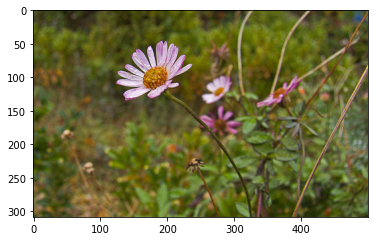

In [ ]:
plt.imshow(img)

In [ ]:
import torchvision.transforms as tt
dataset = ImageFolder(data_dir,tt.Compose([tt.Resize(64),
                                           tt.RandomCrop(64),
                                           tt.ToTensor()]))

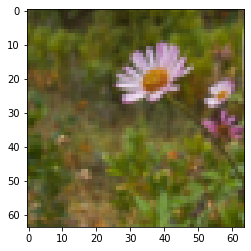

In [ ]:
img,label = dataset[29]
plt.imshow(img.permute((1,2,0)))

In [ ]:
val_pct = 0.1
val_size = int(val_pct*len(dataset))
train_size = len(dataset) - val_size
train_size,val_size

(3891, 432)

In [ ]:
from torch.utils.data import random_split, DataLoader
train_ds, val_ds = random_split(dataset, [train_size, val_size])
train_ds , val_ds

(<torch.utils.data.dataset.Subset at 0x7f6c3f0d7630>,
 <torch.utils.data.dataset.Subset at 0x7f6c3f0d7550>)

In [ ]:
#DataLoaders
batch_size = 128

train_dl = DataLoader(train_ds,
                       batch_size,
                       shuffle = True,
                       num_workers = 4,
                       pin_memory = True)


val_dl =  DataLoader(val_ds,
                       batch_size,
                       shuffle = True,
                       num_workers = 4,
                       pin_memory = True)

In [ ]:
from torchvision.utils import make_grid

def show_batch(dl):
    for images, labels in dl:
        fig, ax = plt.subplots(figsize=(12, 6))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(images, nrow=16).permute(1, 2, 0))
        break

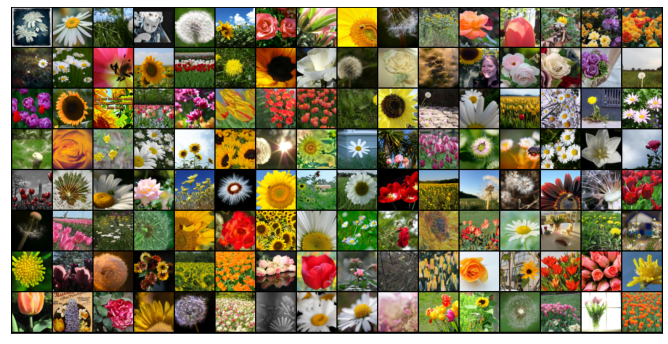

In [ ]:
show_batch(train_dl)

### GPU utilities

In [ ]:
import torch
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [ ]:
torch.cuda.is_available()

True

In [ ]:
device = get_default_device()

In [ ]:
device

device(type='cuda')

In [ ]:
img_gpu = to_device(img,device)
img_gpu.device

device(type='cuda', index=0)

In [ ]:
img,label = dataset[0]

In [ ]:
img.shape

torch.Size([3, 64, 64])

In [ ]:
train_dl = DeviceDataLoader(train_dl,device)
val_dl = DeviceDataLoader(val_dl,device)

## Model & Training Utilities

In [ ]:
import torch.nn as nn
import torch.nn.functional as F
class ImageClassificationBase(nn.Module):
  #Calculate the loss for a Batch of training data
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
      #Calculate the loss & accuracy for a batch of validation data
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [ ]:
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history

##Model

In [ ]:
def conv_block(in_channels, out_channels, pool=False):
    layers = [nn.Conv2d(in_channels, out_channels, kernel_size=3, padding=1), 
              nn.BatchNorm2d(out_channels), 
              nn.ReLU(inplace=True)]
    if pool: layers.append(nn.MaxPool2d(2))
    return nn.Sequential(*layers)
class ResNet9(ImageClassificationBase):
    def __init__(self, in_channels, num_classes):
        super().__init__()
        #input = 128 x 3 x 64 x 64
        self.conv1 = conv_block(in_channels, 64) # 128 x 64 x 64 x 64
        self.conv2 = conv_block(64, 128, pool=True) # 128 x 128 x 32 x 32
        self.res1 = nn.Sequential(conv_block(128, 128),# 128 x 128 x 32 x 32 
                                  conv_block(128, 128))
        
        self.conv3 = conv_block(128, 256, pool=True) # 128 x 256 x 16 x 16
        self.conv4 = conv_block(256, 512, pool=True) # 128 x 512 x 8 x 8
        self.res2 = nn.Sequential(conv_block(512, 512), # 128 x 512 x 8 x 8
                                  conv_block(512, 512))
        
        self.classifier = nn.Sequential(nn.AdaptiveAvgPool2d(1), #128 x 512 x 1 x 1
                                        nn.Flatten(), # 128 x 512
                                        nn.Dropout(0.2),
                                        nn.Linear(512, num_classes))
        
    def forward(self, xb):
        out = self.conv1(xb)
        out = self.conv2(out)
        out = self.res1(out) + out
        out = self.conv3(out)
        out = self.conv4(out)
        out = self.res2(out) + out
        out = self.classifier(out)
        return out

In [ ]:
model = to_device(ResNet9(3, len(dataset.classes)), device)
model

ResNet9(
  (conv1): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (conv2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (res1): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=True)
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU(inplace=Tr

##Pass one batch of input tensor through the model

In [ ]:
for batch in train_dl:
  images, labels = batch
  print('images.shape',images.shape)

  preds = model(images)
  print(images.device)
  print('preds.images',preds.shape)
  break


images.shape torch.Size([128, 3, 64, 64])
cuda:0
preds.images torch.Size([128, 5])


In [ ]:
history = [evaluate(model, val_dl)]
history

[{'val_acc': 0.236328125, 'val_loss': 1.6080055236816406}]

### Training

In [ ]:
history+= fit(5,0.001,model,train_dl,val_dl,torch.optim.Adam)

Epoch [0], train_loss: 1.2807, val_loss: 1.5964, val_acc: 0.3138
Epoch [1], train_loss: 0.9862, val_loss: 1.1124, val_acc: 0.5827
Epoch [2], train_loss: 0.9133, val_loss: 1.1590, val_acc: 0.6165
Epoch [3], train_loss: 0.8697, val_loss: 1.0922, val_acc: 0.5703
Epoch [4], train_loss: 0.8152, val_loss: 1.0233, val_acc: 0.5924


In [ ]:
history+= fit(4,0.0001,model,train_dl,val_dl,torch.optim.Adam)

Epoch [0], train_loss: 0.5604, val_loss: 0.7194, val_acc: 0.7441
Epoch [1], train_loss: 0.5424, val_loss: 0.6424, val_acc: 0.7754
Epoch [2], train_loss: 0.5130, val_loss: 0.6500, val_acc: 0.7715
Epoch [3], train_loss: 0.4930, val_loss: 0.6033, val_acc: 0.7884


In [ ]:
def plot_accuracies(history):
  accuracies = [x['val_acc'] for x in history]
  plt.plot(accuracies,'-x')
  plt.xlabel('Epochs')
  plt.ylabel('Accuracy')
  plt.title('Accuracy vs No.of Epochs')

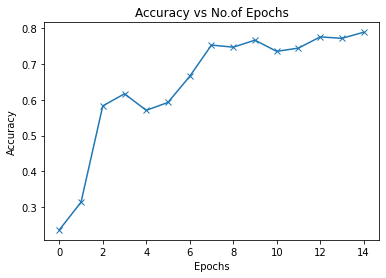

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

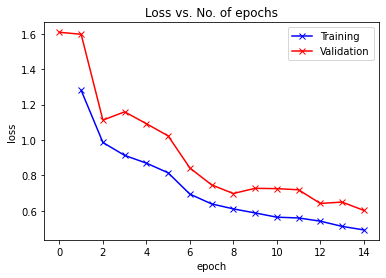

In [ ]:
plot_losses(history)


In [ ]:
jovian.reset()
jovian.log_dataset(image_size = 64)
jovian.log_hyperparams(batch size = 128
                       arch = 'Resent9',
                       epochs = [5,4],
                       lrs= [0.001,0.0001],
                       opt = 'Adam', 'Adam')
jovian.log_metrics(train_loss = history[-1]['train_loss'],
                   val_acc = history[-1]['val_acc']
                   val_loss = history[-1]['val_loss'])

### Test with individual images

In [ ]:
def predict_image(img, model,classes):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return classes[preds[0].item()]

In [ ]:
def show_image_prediction(img,label):
     plt.imshow(img.permute((1,2,0)))
     pred = predict_image(img,model,dataset.classes)
     print('Target:',dataset.classes[label])
     print('predicted:',pred)

Target: dandelion
predicted: dandelion


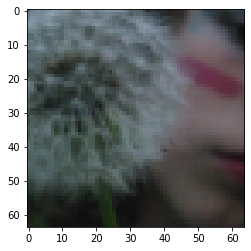

In [ ]:
show_image_prediction(*val_ds[144])

Target: rose
predicted: tulip


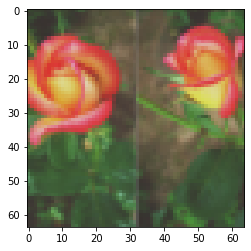

In [ ]:
show_image_prediction(*val_ds[12])

Target: rose
predicted: rose


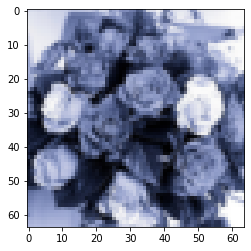

In [ ]:
show_image_prediction(*val_ds[115])

In [ ]:
torch.save(model.state_dict(),'flowers-resnet9.pth')

In [ ]:
!pip install jovian --upgrade --quiet

In [ ]:
import jovian

In [ ]:
jovian.commit(assignment="zerotogans-project",
              outputs = ['flowers-resent9.pth'])

In [ ]:
jovian.submit(assignment="zerotogans-project")

#Transfer Learning

In [ ]:
from torchvision import models

class ResNet34(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=True):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=pretrained)
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)

In [ ]:
model = to_device(ResNet34(len(dataset.classes), pretrained = True),device)

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.cache/torch/hub/checkpoints/resnet34-333f7ec4.pth


In [ ]:
model

ResNet34(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_ru

In [ ]:
import torchvision.transforms as tt
img_size = 224
imagenet_stats = ([0.485, 0.456, 0.406],[0.229, 0.224, 0.225])

dataset = ImageFolder(data_dir,tt.Compose([tt.Resize(64),
                                           tt.RandomCrop(64),
                                           tt.ToTensor(),
                                           tt.Normalize(*imagenet_stats)]))

In [ ]:
#DataLoaders
from torch.utils.data import random_split
from torch.utils.data import DataLoader
train_ds , val_ds = random_split(dataset, [train_size, val_size])
len(train_ds) , len(val_ds)

batch_size = 64

train_dl = DataLoader(train_ds,
                       batch_size,
                       shuffle = True,
                       num_workers = 4,
                       pin_memory = True)


val_dl =  DataLoader(val_ds,
                       batch_size,
                       shuffle = True,
                       num_workers = 4,
                       pin_memory = True)

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

In [ ]:
import torch
from tqdm.notebook import tqdm
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def get_lr(optimizer):
    for param_group in optimizer.param_groups:
        return param_group['lr']

def fit_one_cycle(epochs, max_lr, model, train_loader, val_loader, 
                  weight_decay=0, grad_clip=None, opt_func=torch.optim.SGD):
    torch.cuda.empty_cache()
    history = []
      # Set up cutom optimizer with weight decay
    optimizer = opt_func(model.parameters(), max_lr, weight_decay=weight_decay)
    # Set up one-cycle learning rate scheduler
    sched = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr, epochs=epochs, 
                                                steps_per_epoch=len(train_loader))
    
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        lrs = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            
            # Gradient clipping
            if grad_clip: 
                nn.utils.clip_grad_value_(model.parameters(), grad_clip)
            
            optimizer.step()
            optimizer.zero_grad()
            
            # Record & update learning rate
            lrs.append(get_lr(optimizer))
            sched.step()
        
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        result['lrs'] = lrs
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [ ]:
history = [evaluate(model,train_dl)]
history

[{'val_acc': 0.21696700155735016, 'val_loss': 2.4014387130737305}]

In [ ]:
history+= fit_one_cycle(5,0.001 , model, train_dl,
                         val_dl, weight_decay = 0.01,
                         grad_clip = 0.1, opt_func = torch.optim.Adam)


Epoch [0], train_loss: 0.2586, val_loss: 0.7856, val_acc: 0.7247
Epoch [1], train_loss: 0.5716, val_loss: 1.7140, val_acc: 0.6190
Epoch [2], train_loss: 0.5105, val_loss: 0.6593, val_acc: 0.7656
Epoch [3], train_loss: 0.3358, val_loss: 0.4902, val_acc: 0.8274
Epoch [4], train_loss: 0.2082, val_loss: 0.4715, val_acc: 0.8438


In [ ]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline

def denormalize(images, means, stds):
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_image(img_tensor, label):
    print('Label:', dataset.classes[label], '(' + str(label) + ')')
    img_tensor = denormalize(img_tensor, *imagenet_stats)[0].permute((1, 2, 0))
    plt.imshow(img_tensor)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

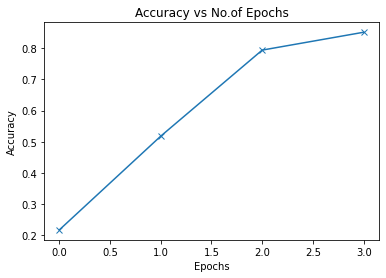

In [ ]:
plot_accuracies(history)

In [ ]:
def plot_losses(history):
    train_losses = [x.get('train_loss') for x in history]
    val_losses = [x['val_loss'] for x in history]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

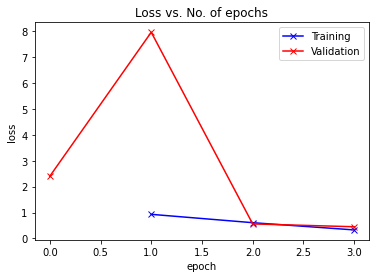

In [ ]:
plot_losses(history)

In [ ]:
import numpy as np
def plot_lrs(history):
    lrs = np.concatenate([x.get('lrs', []) for x in history])
    plt.plot(lrs)
    plt.xlabel('Batch no.')
    plt.ylabel('Learning rate')
    plt.title('Learning Rate vs. Batch no.');

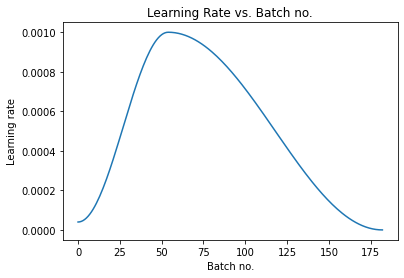

In [ ]:
plot_lrs(history)

In [ ]:
import torch
import matplotlib.pyplot as plt
%matplotlib inline

def denormalize(images, means, stds):
    if len(images.shape) == 3:
        images = images.unsqueeze(0)
    means = torch.tensor(means).reshape(1, 3, 1, 1)
    stds = torch.tensor(stds).reshape(1, 3, 1, 1)
    return images * stds + means

def show_image(img_tensor, label):
    print('Label:', dataset.classes[label], '(' + str(label) + ')')
    img_tensor = denormalize(img_tensor, *imagenet_stats)[0].permute((1, 2, 0))
    plt.imshow(img_tensor)

Label: daisy (0)
Predicted: daisy


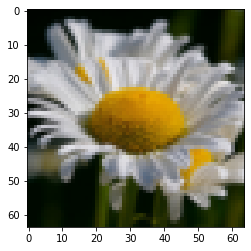

In [ ]:
img, label = val_ds[0]
show_image(img , label)
pred = predict_image(img , model, dataset.classes)
print('Predicted:',pred)

Label: rose (2)
Predicted: rose


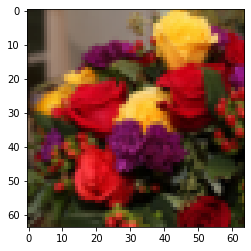

In [ ]:
img, label = val_ds[150]
show_image(img , label)
pred = predict_image(img , model, dataset.classes)
print('Predicted:',pred)

Label: sunflower (3)
Predicted: sunflower


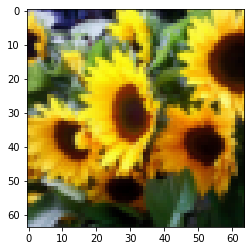

In [ ]:
img, label = val_ds[200]
show_image(img , label)
pred = predict_image(img , model, dataset.classes)
print('Predicted:',pred)